# Machine-learning modelling of Infrasound Transmission-Loss (MITL)
MITL generates infrasound ground Transmission Loss (TL) profiles over 1000 km based on realistic and range-dependent atmospheric models. MITL is based on a Convolutional Neural Network (CNN) architecture to segment 2d wind profiles (range vs altitude) and produce realistic TL estimates.

Reference paper: Brissaud, Q., Näsholm, S. P., Turquet, A., & Le Pichon, A. (2023). Predicting infrasound transmission loss using deep learning. Geophysical Journal International, 232(1), 274-286. doi: 10.1093/gji/ggac307

<center><img src="model_and_dataset.png" width="600"/></center>
Figure: MITL dataset augmentation and workflow

### Load standard libraries

In [5]:
%matplotlib notebook
import pandas as pd
import numpy as np
import os
from obspy.core.utcdatetime import UTCDateTime
import matplotlib.pyplot as plt
from tensorflow import random as tf_random

### Load custom libraries

In [2]:
import sys
import build_machine_learning, utils_figures
from build_machine_learning import build_dataset

### Set dataset and model parameters

In [3]:
## Directories
main_dir   = './'
figure_dir = './'

## Formatting strings
name_model = 'model_b{batch_size}_d{coef_downsample}_u{coef_upsample}_t{test_size}_seeds{npseed}.{tfseed}{ext}/'
file_name = 'dataset_{model}_{input}_{output}_{ncomp}_{n_components_output}{ext}.pkl'

## Model parameters
model_parameters = {
    'model_dir': './model_b32_d20_u4_t0.15_seeds5.2_new_dataset/',
    'optimization': False,
    'loss_metric': 'mse',
    'metrics': ['mse'],
    'activation_result': None,
    'dropout_factor': 0.,
    'epochs': 120,
    'kernel_size': 5,
    'test_size': 0.15,
    'batch_size': 32,
    'verbose': 2, 
    'factor': 0.5, 
    'min_lr': 1e-8, 
    'cooldown': 3, 
    'patience': 12,
    'type_model': 'CNN',
    'opt_par': [1e-3, 2, 50, 2., 'relu', 3, 5, 2.],
    'full_random': False,
    'scaler_output': 'standard',#'standard',#'minmax',
    'type_split': 'nb_slice_orig',#'veff-20-50',
    'kfold_sets': [],
    'seed_split': 3, 
    'seed_tf': 2,
    'name_model': name_model,
    'ext': '_new_dataset_temp', # Name extension for model directory   
}

## Dataset parameters
dataset_parameters = {
    'construct_new_dataset': False,
    'method': 'tloss',
    'method_input': 'downsample_1channel',
    'method_output': 'linear',
    'n_components_input': 10,
    'n_components_output': 500,
    'r_normalization': 1,
    'coef_downsample': 20,
    'coef_upsample': 4,
    'range_distance': [2., 999.],
    'use_ceff_inputs': True,
    'alt_veffs': [[1., 15.], [35., 60.], [60., 100.]],
    #'ext': '_upwind' # Name extension for dataset file        
    'ext': '' # Name extension for dataset file        
}

### Make training deterministic

In [6]:
## Initialize random numbers for reproductibility
np.random.seed(model_parameters['seed_split'])
tf_random.set_seed(model_parameters['seed_tf'])

### Load dataset

In [7]:
## Load previously-generated dataset and model
dataset_parameters['construct_new_dataset'] = False
output_dir_old = main_dir
#build_machine_learning.generate_c_profiles_CPUs(output_dir_old, nb_CPU=1)
model_parameters_sub = build_machine_learning.get_sub_dict_parameters(['type_model'], model_parameters)
one_dataset_old = build_machine_learning.get_dataset(output_dir_old, **dataset_parameters, **model_parameters_sub, nb_CPU=16, file_name=file_name, name_file='list_simulations.csv')

#######################
#######################
Load dataset dataset_CNN_downsample_1channel_linear_20_4_500.pkl
#######################
#######################


### Load CNN model

In [8]:
dataset_parameters_sub = build_machine_learning.get_sub_dict_parameters(['coef_downsample', 'coef_upsample'], dataset_parameters)
model2 = build_machine_learning.load_or_train_ML_model(one_dataset_old, output_dir_old, save_model=True, **model_parameters, **dataset_parameters_sub)
model2.split_train_test(seed=5, test_size=model_parameters['test_size'], full_random=model_parameters['full_random'], type=model_parameters['type_split'])
alt_veffs=[[1., 15.], [5., 20.], [35., 60.], [20., 50.], [40., 50.], [50., 100.], [60., 120.], [80., 120.]]
external_types=['atmos_1976' for i in alt_veffs]
one_dataset_old.determine_dataset_properties(alt_veffs=alt_veffs, ranges=np.linspace(0., 1000, 10), use_external_vel=True, external_types=external_types, external_files={'MSIS_file': '/adhocdata/infrasound/2021_seed_infrAI/model_atmos_fixed/msise_temp_models.csv', 'atmos_1976':'/adhocdata/infrasound/2021_seed_infrAI/model_atmos_fixed/atmos1976_temp_models.csv'}, external_type_ground='atmos_1976')

Conversion val accuracy


### Plot results in the testing dataset

<IPython.core.display.Javascript object>


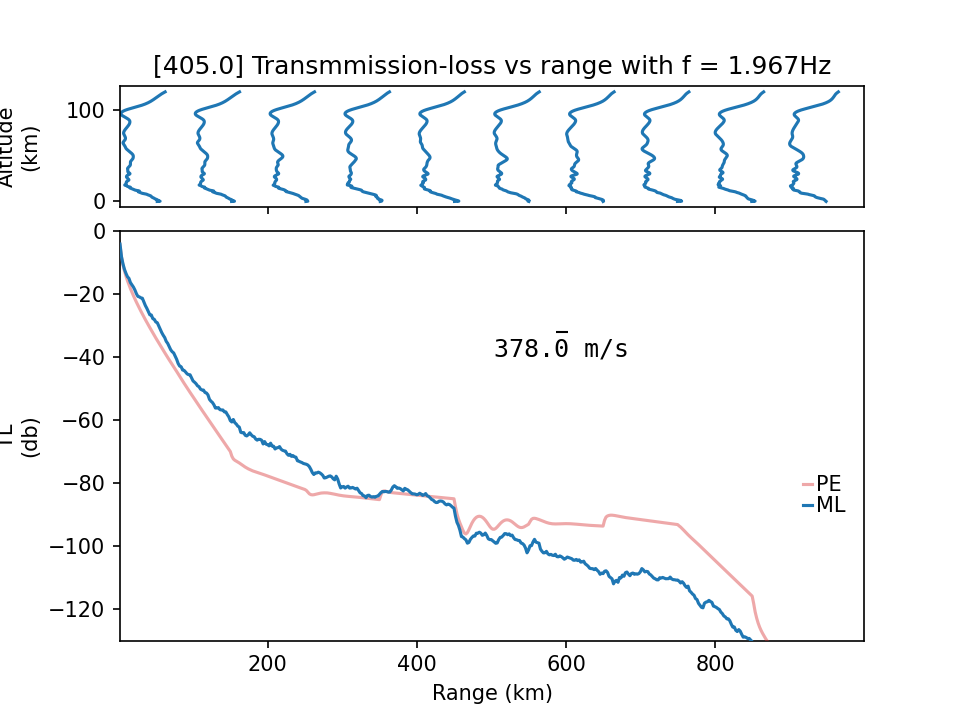

1/1 [==============================] - 2s 2s/step


<IPython.core.display.Javascript object>


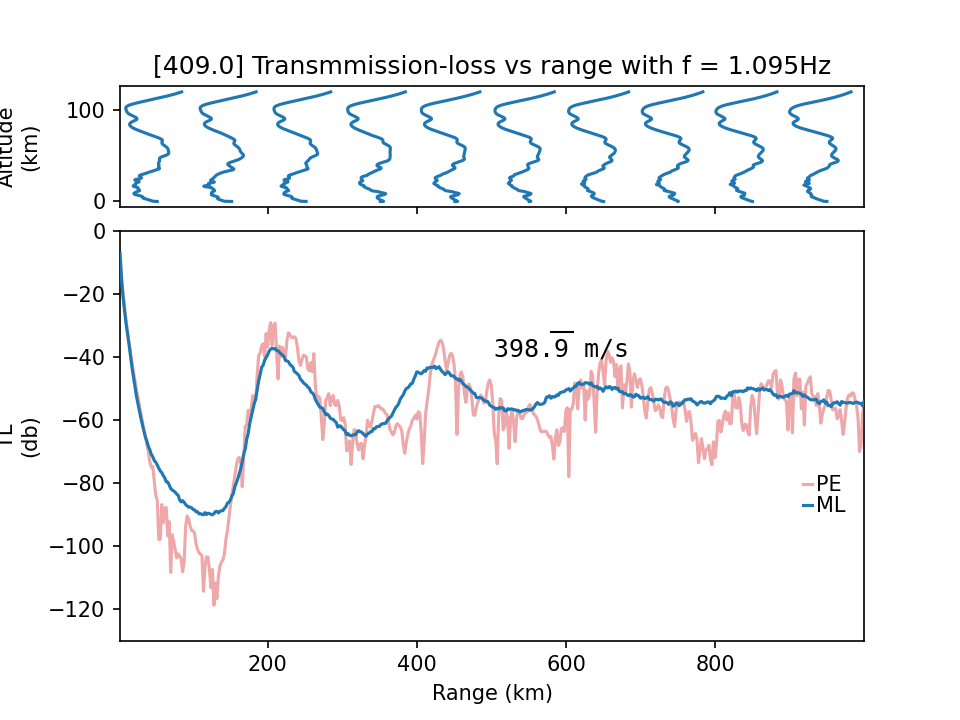

1/1 [==============================] - 0s 54ms/step


In [9]:
utils_figures.compare_TL(np.arange(50,52), model2, figure_dir, additional_homogeneous=[], additional_f0s=[], dataset='test', show_predictions=True)